In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [26]:

def create_adjacency_matrix_from_links(num_nodes, links):
    """
    Create an adjacency matrix based on the provided node links.

    Args:
        num_nodes (int): The total number of nodes in the graph.
        links (list of tuples): Each tuple represents a directed edge from one node to another (from_node, to_node).

    Returns:
        np.ndarray: The adjacency matrix.
    """
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    
    for link in links:
        from_node, to_node = link
        adjacency_matrix[from_node-1, to_node-1] = 1  # -1 because MATLAB indexing starts at 1
    
    return adjacency_matrix


def init_env():
    # connectivity_matrix = np.array(
    #     [
    #         # 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
    #         [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
    #         [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 2
    #         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 3
    #         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 4
    #         [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 5
    #         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
    #         [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # 7
    #         [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 8
    #         [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9
    #         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 10
    #         [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 11
    #         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],  # 12
    #         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 13
    #         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 14
    #         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 15
    #     ]
    # )
    
    links = [
        (5, 6), (6, 5), (6, 11), (7, 5), (7, 10), (8, 6), (8, 9), (9, 6), (9, 2), (10, 7), (10, 13),
        (1, 6), (1, 7), (1, 3), (11, 6), (11, 8), (11, 14), (12, 6), (12, 8), (12, 15), (2, 9), (2, 4),
        (13, 9), (3, 1), (3, 2), (4, 1), (14, 6), (14, 12), (15, 6), (15, 12), (7, 12), (12, 7), (5, 1), (1, 5)
    ]
    
    num_nodes = 15
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    
    desired_centrality = np.array(
        [0.08, # 1
        0.06, # 2
        0.14, # 3
        0.08, # 4
        0.04, # 5
        0.02, # 6
        0.06, # 7
        0.03, # 8
        0.04, # 9
        0.08, # 10
        0.13, # 11
        0.06, # 12
        0.04, # 13
        0.07, # 14
        0.07] # 15
    )  # Example centrality

    initial_opinions = np.linspace(0, 1, len(desired_centrality))

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        desired_centrality=desired_centrality,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.01,
        max_steps=1_000_000
    )

    env.reset()
    
    return env

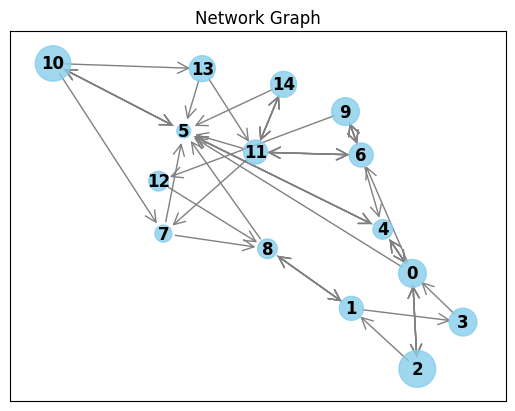

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [27]:
env = init_env()
env.render(mode="matplotlib")
env.reset()

In [28]:
env.centralities

array([0.07999997, 0.05999994, 0.13999999, 0.08      , 0.04000005,
       0.02000002, 0.05999998, 0.03000001, 0.04000002, 0.08000001,
       0.13      , 0.05999997, 0.04000002, 0.07000001, 0.07      ])

In [29]:
def brute_force_time_space_allocation(env, M):
    """
    Perform brute-force time-space allocation search to find the optimal control actions.

    Args:
        env (NetworkGraph): The NetworkGraph environment.
        M (int): Number of stages.

    Returns:
        tuple: Best control action matrix (Ustar) and the corresponding state evolution (Xstar).
    """
    N = env.num_agents  # Number of agents
    ubar = env.max_u  # Maximum control input
    K = N  # Total budget constraint in terms of ubar count
    x0 = env.opinions  # Initial opinions
    L = env.L  # Laplacian matrix
    eigv = env.centralities  # Centrality vector, used for final stage value

    nbits = N * M
    Nsol = 2 ** nbits  # Total number of solutions
    cstar = float('inf')  # Initialize best cost as infinity
    Xstar = None  # Initialize best state trajectory
    Ustar = None  # Initialize best control matrix

    # Precompute the exponential of the Laplacian for constant spacing
    constantspacing = False  # Assuming constant spacing here; modify if needed
    if constantspacing:
        expL = np.linalg.matrix_power(np.exp(-L), int(env.tau))

    for i in range(Nsol):
        U = np.array([int(x) for x in bin(i)[2:].zfill(nbits)]).reshape(N, M)
        if np.sum(U) > K:
            continue  # Skip configurations that exceed the budget constraint

        X = np.zeros((N, M + 1))
        X[:, 0] = x0  # Set initial state

        for k in range(M):
            u = U[:, k] * ubar
            xplus = u * env.desired_opinion + (1 - u) * X[:, k]

            if k < M - 1:
                if constantspacing:
                    X[:, k + 1] = np.dot(expL, xplus)
                else:
                    X[:, k + 1] = np.linalg.matrix_power(np.exp(-L), int(env.tau * (k + 1))) @ xplus
            else:
                X[:, k + 1] = np.dot(eigv, xplus)

        c = np.abs(X[0, -1] - env.desired_opinion)
        if c < cstar:
            cstar = c
            Xstar = X
            Ustar = U

    return Ustar, Xstar, cstar

# Example usage
env = init_env()  # Initialize the environment with desired parameters
M = 4  # Number of stages
Ustar, Xstar, cstar = brute_force_time_space_allocation(env, M)

KeyboardInterrupt: 

In [34]:
import numpy as np
from itertools import product

def brute_force_time_allocation_per_stage(env, M, K, Ts=0.5):
    """
    Implement the brute force algorithm for time allocation search (per stage).

    Args:
        env (NetworkGraph): The NetworkGraph environment.
        M (int): The number of stages.
        K (int): The total budget in units of max_u.
        Ts (float): Time step (used if time spacings are constant).

    Returns:
        tuple: (betastar, Xstar, cstar) where
               - betastar: Optimal budget allocation across stages.
               - Xstar: The resulting state trajectories.
               - cstar: The corresponding cost.
    """
    N = env.num_agents  # Number of agents
    ubar = env.max_u  # Maximum control input
    eigv = env.centralities  # Eigenvector corresponding to the smallest eigenvalue of L
    L = env.L  # Laplacian matrix
    x_t0 = env.opinions  # Initial opinions
    d = env.desired_opinion  # Desired opinion

    # Define time spacings
    deltas = Ts * np.ones(M - 1)  # assuming constant time spacings

    cstar = np.inf
    Xstar = None
    betastar = None
    
    Nsol = (K + 1) ** M
    stepdisp = 0.01
    
    if stepdisp > 0:
        print('Searching space allocations...')

    for i in range(Nsol):
        beta = np.base_repr(i, base=K + 1).zfill(M)
        # Convert each character to an integer using base K + 1
        beta = np.array([int(b, K + 1) for b in beta])
        
        if np.any(beta > N) or np.sum(beta) > K:
            continue

        X = np.zeros((N, M + 1))
        X[:, 0] = x_t0
        U = np.zeros((N, M))

        for k in range(M):
            x = X[:, k]
            if env.m == 1:
                scores = eigv * np.abs(x - d)
            else:
                scores = np.zeros(N)
                for c in range(env.m):
                    scores[env.irange[c]] = env.Nc[c] * (env.eigvc[c] * np.abs(x[env.irange[c]] - d))

            order = np.argsort(-scores)
            U[order[:beta[k]], k] = 1

            u = U[:, k] * ubar
            xplus = u * d + (1 - u) * x

            if k < M:
                if np.all(deltas == deltas[0]):
                    expL = np.linalg.matrix_power(np.exp(-L * deltas[0]), 1)
                    X[:, k + 1] = expL @ xplus
                else:
                    X[:, k + 1] = np.exp(-L * deltas[k]) @ xplus
            else:
                if env.m == 1:
                    X[:, k + 1] = eigv @ xplus
                else:
                    for c in range(env.m):
                        X[env.irange[c], k + 1] = env.eigvc[c] @ xplus[env.irange[c]]

        c = np.mean(np.abs(X[:, -1] - d))
        
        if c < cstar:
            cstar = c
            Xstar = X
            betastar = beta
            
        if stepdisp > 0 and i / Nsol >= stepdisp:
            print(f'{int(i / Nsol * 100)}%')
            stepdisp += 0.01

    print('100%')
    return betastar, Xstar, cstar

env = init_env()  # Initialize the environment with desired parameters
env.m = 1
M = 4  # Number of stages
K = 15
betastar, Xstar, cstar = brute_force_time_allocation_per_stage(env, M, K)

Searching space allocations...
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
25%
25%
26%
27%
28%
29%
31%
31%
32%
33%
34%
35%
37%
37%
38%
39%
40%
41%
43%
43%
44%
45%
46%
50%
50%
50%
50%
51%
52%
56%
56%
56%
56%
57%
58%
62%
62%
62%
62%
63%
64%
68%
68%
68%
68%
69%
70%
75%
75%
75%
75%
75%
76%
81%
81%
81%
81%
81%
82%
87%
87%
87%
87%
93%
100%


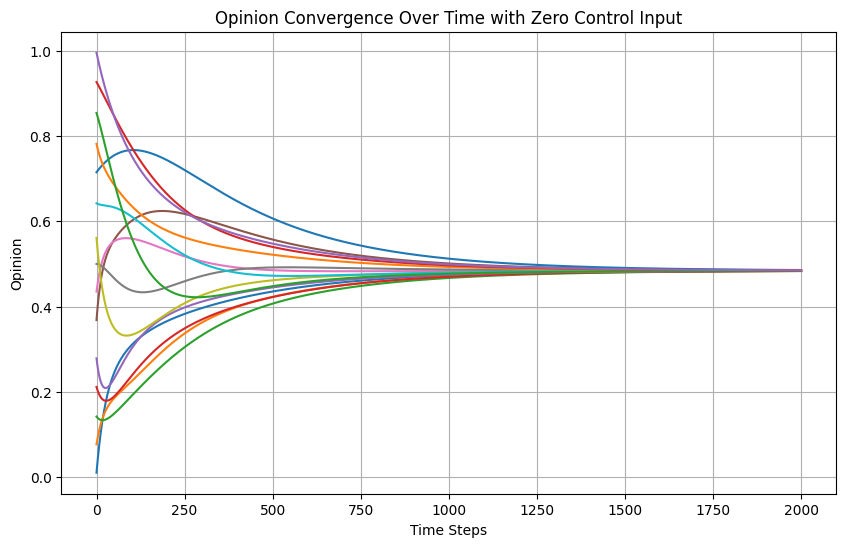

In [20]:
# Define the number of steps for which to apply the zero control input
num_steps = 2000

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions

plot_opinions_over_time(opinions_over_time)

In [21]:

env = init_env()

budget = 2

# Applying the optimal control strategy in the environment
optimal_u = optimal_control_action(env, budget=budget)
print(optimal_u)

opinions, reward, done, truncated, info = env.step(optimal_u)
opinions

[2.00000000e-01 2.00000000e-01 2.00000000e-01 2.00000000e-01
 2.00000000e-01 2.77555756e-16 2.00000000e-01 2.00000000e-01
 2.00000000e-01 2.00000000e-01 2.00000000e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


array([0.20781781, 0.26131644, 0.31332582, 0.36900555, 0.42227618,
       0.37258892, 0.54765519, 0.59932544, 0.64786682, 0.71377941,
       0.77225519, 0.78368153, 0.85531211, 0.9271717 , 0.99606986])

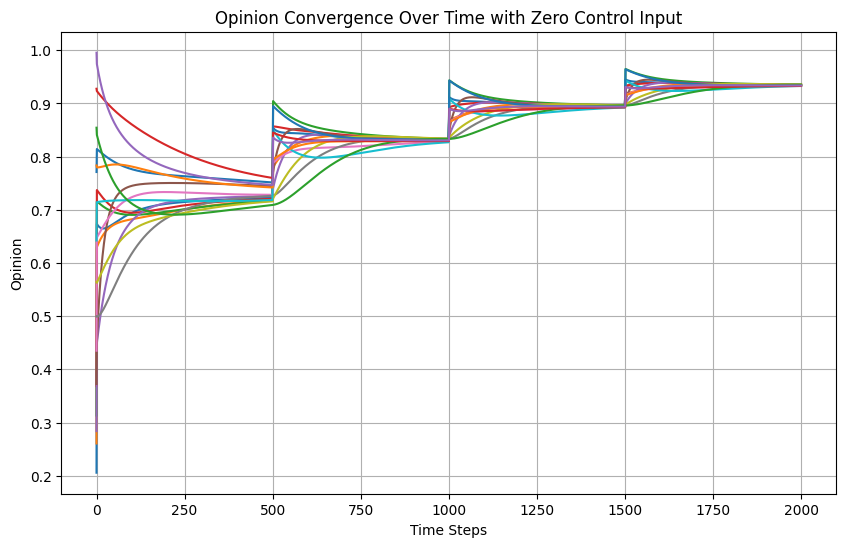

In [127]:
env = init_env()

# Define the number of steps for which to apply the zero control input
num_steps = 2000
k = 500  # Apply optimal control every k steps
N = 5  # Number of consecutive steps to apply optimal control
budget = 1  # Example budget

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation
for i in range(num_steps):
    if i % k == 0:
        # Apply the optimal control every k steps for N consecutive steps
        for j in range(N):
            if i + j < num_steps:
                optimal_u = optimal_control_action(env, budget=budget)
                # print(f"Applying optimal control at step {i + j}: {optimal_u}")
                opinions, reward, done, truncated, info = env.step(optimal_u)
                opinions_over_time[i + j] = opinions
        # Skip the next N-1 steps as they are already processed
        i += N - 1
    else:
        # Apply zero control input at other steps
        optimal_u = np.zeros(env.num_agents)
        opinions, reward, done, truncated, info = env.step(optimal_u)
        opinions_over_time[i] = opinions

# Plot the collected opinions over time
plot_opinions_over_time(opinions_over_time)

In [128]:
env = init_env()
M = 3 # Number of campaigns
Q = 15  # Total budget

optimal_budget_allocation = brute_force_strategy(env, M, Q)
print("Optimal budget allocation:", optimal_budget_allocation)

Optimal budget allocation: [3 3 3 3]


In [129]:
env = init_env()

# Example usage with the environment
M = 5  # Number of campaigns
Q = 20  # Total budget

optimal_budget_allocation = dynamic_programming_strategy(env, M, Q)
print("Optimal budget allocation for each campaign:", optimal_budget_allocation)


Optimal budget allocation for each campaign: [4 3 3 3 3 4]


Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 6.104991006235625
Final Error: 3.3306690738754696e-15


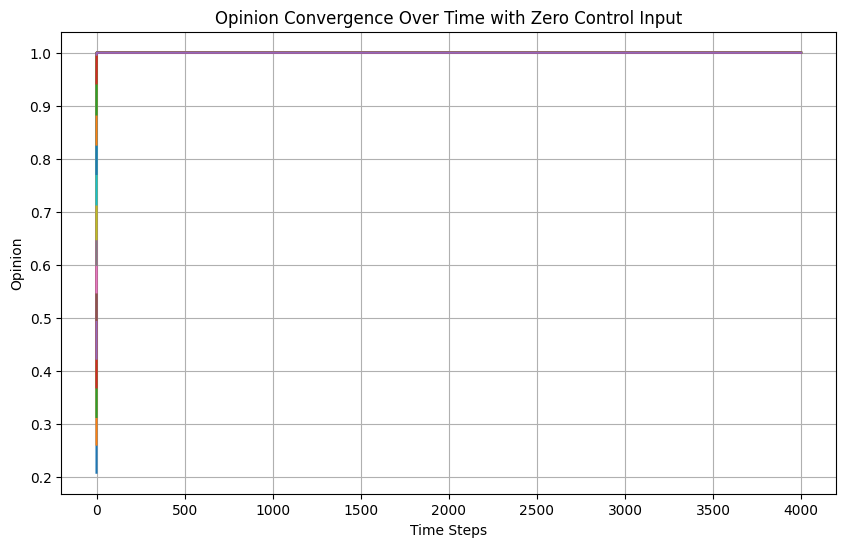

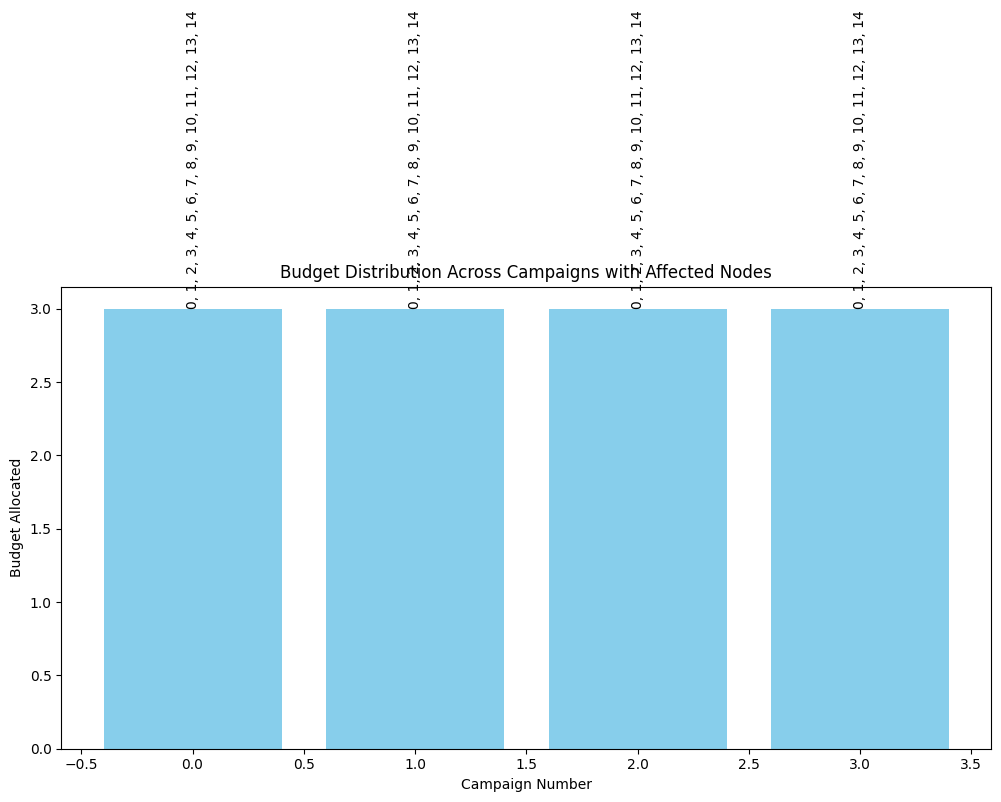

In [149]:
# Example usage
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env, num_steps, M, Q, env.tau, strategy='brute_force', campaign_length=campaign_length)

# Compute errors
overall_error = compute_overall_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)

Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 18280.515590749153
Final Error: 3.168549164594347


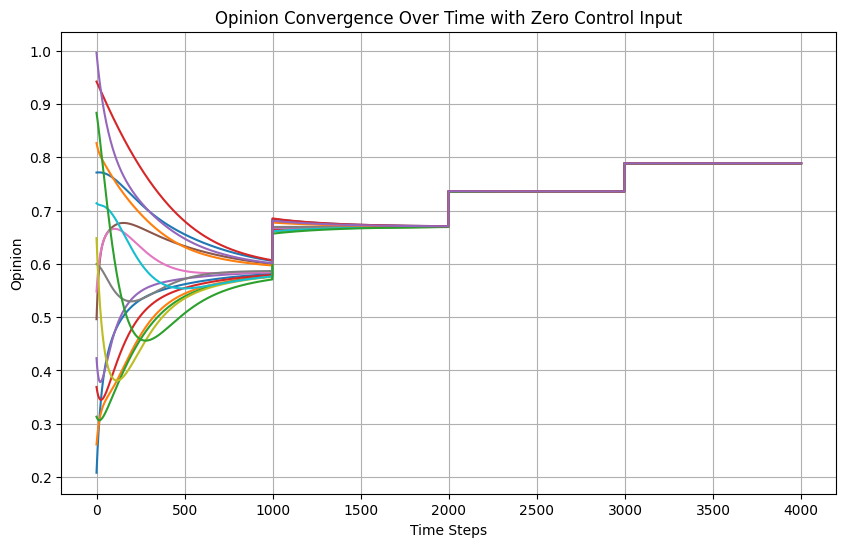

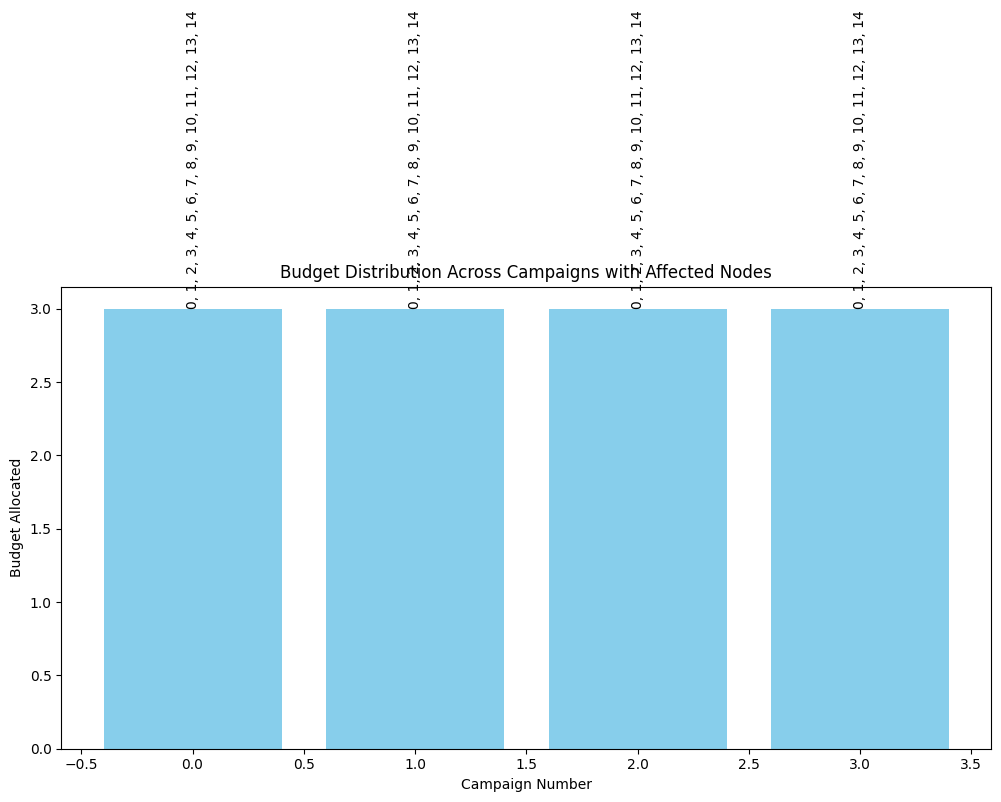

In [152]:
# Example usage for Brute Force Strategy
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Campaign length in continuous time

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env, num_steps, M, Q, sample_time=env.tau, strategy='brute_force', campaign_length=campaign_length
)

# Compute errors
overall_error = compute_overall_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)


Uncontrolled Case - Overall Error: 30965.272396430188
Final Error: 7.73571573387295


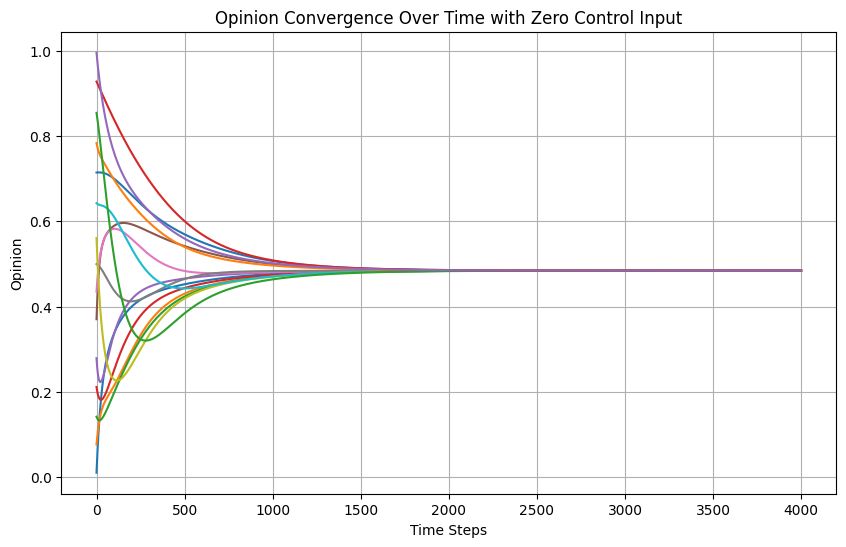

In [141]:
# Example usage for all strategies
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with no control (uncontrolled case)
opinions_over_time_uncontrolled = run_uncontrolled_experiment(env, num_steps)
overall_error_uncontrolled = compute_overall_error(opinions_over_time_uncontrolled, env.desired_opinion)
final_error_uncontrolled = compute_final_error(opinions_over_time_uncontrolled, env.desired_opinion)

print(f"Uncontrolled Case - Overall Error: {overall_error_uncontrolled}")
print(f"Final Error: {final_error_uncontrolled}")
plot_opinions_over_time(opinions_over_time_uncontrolled)


Broadcast Strategy - Overall Error: 24772.217917144164
Final Error: 6.188572587098369


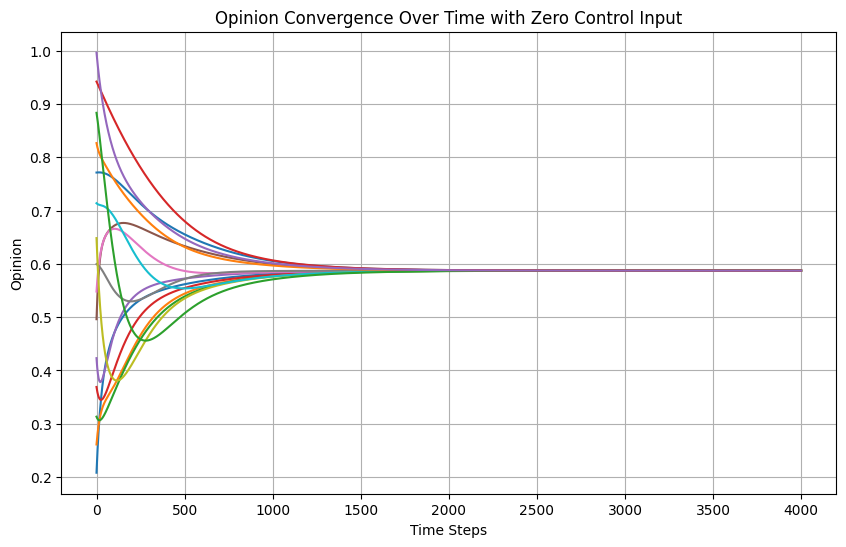

In [142]:
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
Q = 15  # Total budget
broadcast_duration = 1  # Number of steps to apply the max control input

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast = run_broadcast_strategy(env, num_steps, broadcast_duration)
overall_error_broadcast = compute_overall_error(opinions_over_time_broadcast, env.desired_opinion)
final_error_broadcast = compute_final_error(opinions_over_time_broadcast, env.desired_opinion)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)


### Aligning with matlab version

Adjacency Matrix:
 [[0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]]


In [15]:
connectivity_matrix = np.array(
        [
            # 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
            [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
            [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 2
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 3
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 4
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 5
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # 7
            [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 8
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 10
            [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 11
            [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],  # 12
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 13
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 14
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 15
        ]
    )

np.array(adjacency_matrix) == connectivity_matrix

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  T